In [135]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import tt

class SimplePDE:
  """
  Solve simple diffusion problem on [0,1] using P1 finite elements.
  """

  def __init__(self, N):
    self.N = N

  def linear_system(self, k, coeff):
    """
    Assemble k-th component of linear system (depending on k-th component of 
    coefficient.
    """
    [num_coeff, nx, I] = np.shape(coeff)

    A = [None] * I
    F = [None] * I

    if k == 0: # diffusion part
      a = coeff[0,:,:]

      if np.min(a) <= 0:
        warnings.warn(f'Non positive components')

      for i in range(I):
        # part of rhs dependent on a (0 here)
        Fi = np.zeros((self.N+1,1))
        F[i]= Fi
        
        # assemble A, a piecewise constant on grid
        # linearly dependent on a
        Ai = np.zeros((self.N+1,self.N+1))
        Ai.flat[self.N+2::self.N+2] = (a[1:,i] + a[:-1, i]) * self.N # set diag
        Ai.flat[1::self.N+2] = -a[:,i] * self.N # set first upper diag
        Ai.flat[self.N+1::self.N+2] = -a[:,i] * self.N # set first lower diag
        Ai[[0,-1]] = 0 # for dirichlet boundary
        A[i] = Ai

    elif k == 1: # convection part
      v = coeff[0,0,:]

      for i in range(I):
        # part of rhs dependent on coeff (0 here)
        Fi = np.zeros((self.N+1,1))
        F[i]= Fi

        # linearly dependent on v
        Ai = np.zeros((self.N+1,self.N+1))
        Ai.flat[1::self.N+2] = v[i]# set first upper diag
        Ai.flat[self.N+1::self.N+2] = -v[i] # set first lower diag
        Ai[[0,-1]] = 0 # for dirichlet boundary
        A[i] = Ai
      
    elif k == 2: # constant part
      for i in range(I):
        # constant part of rhs
        Fi = np.full((self.N+1,1), 10/(self.N)) # assume RHS = 1 
        Fi[[0,-1]] = 0 # boundary condition
        F[i] = Fi

        # constant part of matrix
        Ai = np.zeros((self.N+1,self.N+1))

        # convection term
        v = 1
        Ai.flat[1::self.N+2] = v # upper diag
        Ai.flat[self.N+1::self.N+2] = -v  # lower diag
        # from boundary condition
        Ai[[0,-1]] = 0
        Ai[0,0] = 1
        Ai[-1,-1] = 1

        A[i] = Ai      
      
    else:
      raise Exception(f"No component {k} implemented.")
    
    return A, F

  def solve(self, coeff):
    """
    Assemble and solve FE problem for coeff.
    """
    [num_coeff, nx, I] = np.shape(coeff[0])
    
    U = []

    A0, b0 = self.linear_system(0, coeff[0])
    A1, b1 = self.linear_system(1, coeff[1])
    A2, b2 = self.linear_system(2, coeff[2])

    for i in range(I):
      U.append(np.linalg.solve(A0[i] + A1[i] + A2[i], b0[i] + b1[i] + b2[i]).reshape((-1,1)))
    
    return U

class diffusion_coeff:

  def __init__(self, Nx, Ny, offset, var):
    self.Nx = Nx
    self.Ny = Ny
    self.offset = offset
    self.var = var

  def __call__(self, X):
    c = np.full(len(X), self.offset,dtype=float)
    for i, x in enumerate(X):
      k = np.arange(1,len(x)-1)
      c[i] += np.sum(np.exp(-k) * np.sin(np.pi*k*x[0]/(self.Nx-1)) \
                      * (x[k]/(self.Ny-1) - 0.5) * self.var)
    return c

### PDE test

Solve the PDE using P1 finite elements for a random parameter

Text(0, 0.5, 'A')

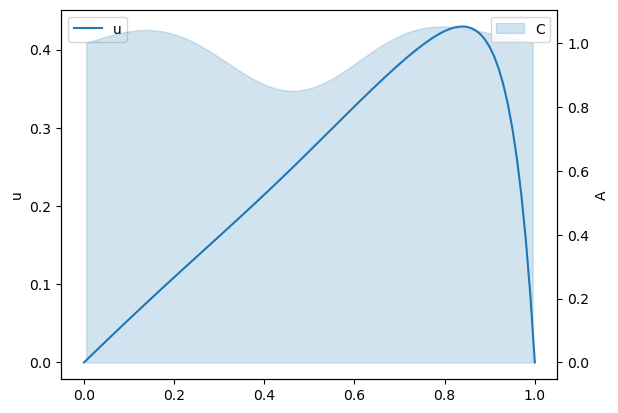

In [136]:
Nx = 100    # spatial resolution
Ny = 10       # parameter resolution
n_a_param = 5 # number of parameters for diffusion coeff
n_param = n_a_param + 1
offset = 1   # parameter mean
var = 4       # 'variance' of the parameters
v_min, v_max = -10, 10

# get random params
rng = np.random.default_rng()
y = rng.uniform(0, Ny-1, n_a_param)
v = rng.uniform(v_min, v_max)
X = np.hstack([np.arange(Nx).reshape((-1,1)), np.tile(y, [Nx,1]), np.zeros((Nx,1))])

cfun = diffusion_coeff(Nx, Ny, offset, var)

C_true = cfun(X)

PDE_fun = SimplePDE(Nx)

U = PDE_fun.solve([C_true.reshape(1,-1,1), v * np.ones((1,1,1)), np.ones((1,1,1))])
U = np.ravel(U[0])

fig, ax = plt.subplots()
ax2 = ax.twinx()

x = np.arange(Nx+1) / Nx
midpoints = (np.arange(Nx) + 0.5) / Nx
p = ax.plot(x, U, label='u')
ax2.fill_between((np.arange(len(C_true)) + 0.5) / (len(C_true)), C_true, alpha=0.2, color=p[0].get_color(), label='C')

ax.set_ylabel('u')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('A')

### Get TT approx of coefficient

In [137]:
from tt import cross

# random init tensor
C_a = tt.rand(np.array([Nx] + [Ny] * n_param),r=3)
# compute TT approx using TT-cross
C_a = tt.cross.rect_cross.cross(cfun, C_a, eps = 1e-8, kickrank=1)
C_a = C_a.round(1e-12)

print("Coefficient ranks: ", C_a.r)
print("Coefficient dims: ", C_a.n)

swp: 0/9 er_rel = 2.8e+01 er_abs = 3.0e+05 erank = 5.2 fun_eval: 2520
swp: 1/9 er_rel = 3.2e-02 er_abs = 3.4e+02 erank = 9.0 fun_eval: 8640
swp: 2/9 er_rel = 1.2e-15 er_abs = 1.3e-11 erank = 14.4 fun_eval: 24660
Coefficient ranks:  [1 6 5 4 3 2 1 1]
Coefficient dims:  [100  10  10  10  10  10  10]


### Test TT approx

Compare TT approx of coefficient $A$ vs the true coefficient $A$ for the random parameter sample from above

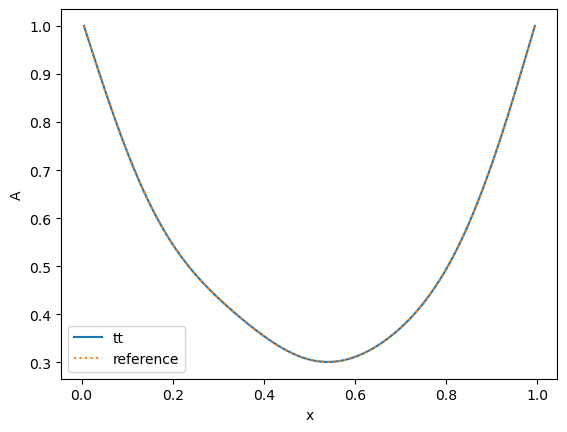

In [138]:
# eval TT-approx of coeff
y = rng.integers(0, Ny, n_a_param)
C_eval = np.empty(Nx)
for i in range(Nx):
  C_eval[i] = C_a[np.concatenate([[i , 0], y])]

X = np.hstack([np.arange(Nx).reshape((-1,1)), np.zeros((Nx,1)), np.tile(y, [Nx,1])])
C_true = cfun(X)

fig, ax = plt.subplots()

x = (np.arange(0, Nx) + .5) / Nx
ax.plot(x, C_eval, label='tt')
ax.plot(x, C_true, ls='dotted', label="reference")
ax.set_xlabel('x')
ax.set_ylabel('A')
ax.legend()

In [139]:
cores = [np.ones((1,1,1))]
for i in range(n_param-1):
  cores += [np.ones((1,Ny,1))]

cores += [np.linspace(v_min,v_max, Ny).reshape(1,-1,1)]

C_v = tt.vector.from_list(cores)

# helper tensor that is constant 1
cores = [np.ones((1,1,1))]
for i in range(n_param):
  cores += [np.ones((1,Ny,1))]

C_const = tt.vector.from_list(cores)

### ALS-cross test

In [154]:
from als_cross import als_cross

test = als_cross(
  [C_a, C_v, C_const], 
  PDE_fun,
  1e-8,
  # random_init=5,
  kickrank=3
  )

test.iterate(7)
print(test.get_stats())

u = test.get_tensor()

print('Ranks', u.r)

= swp=1 core 0, max_dx=1.000e+00, max_rank = 6
= swp=1 core 1>, dx=1.000e+00, rank = [9, 7]
= swp=1 core 2>, dx=1.000e+00, rank = [7, 6]
= swp=1 core 3>, dx=1.000e+00, rank = [6, 5]
= swp=1 core 4>, dx=1.000e+00, rank = [5, 3]
= swp=1 core 5>, dx=1.000e+00, rank = [3, 2]
= swp=1 fwd finish, max_dx=1.000e+00, max_rank = 9
= swp=2 core <6, dx=0.000e+00, rank = [3, 1]
= swp=2 core <5, dx=2.114e-01, rank = [4, 3]
= swp=2 core <4, dx=3.741e-01, rank = [7, 4]
= swp=2 core <3, dx=1.749e-01, rank = [8, 7]
= swp=2 core <2, dx=3.489e-01, rank = [9, 8]
= swp=2 core <1, dx=3.355e-01, rank = [12, 9]
= swp=3 core 0, max_dx=3.741e-01, max_rank = 12
= swp=3 core 1>, dx=1.750e-02, rank = [15, 11]
= swp=3 core 2>, dx=2.819e-02, rank = [11, 10]
= swp=3 core 3>, dx=1.741e-02, rank = [10, 9]
= swp=3 core 4>, dx=5.929e-04, rank = [9, 5]
= swp=3 core 5>, dx=5.151e-03, rank = [5, 4]
= swp=3 fwd finish, max_dx=4.024e-01, max_rank = 15
= swp=4 core <6, dx=0.000e+00, rank = [5, 1]
= swp=4 core <5, dx=3.658e-02, 

### Test ALS-cross accuracy

Compare ALS cross approximation vs PDE solution for a random sample

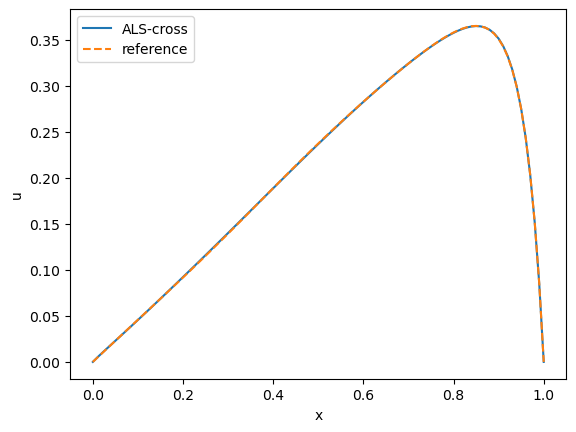

In [162]:
# get random parameter
y = rng.integers(0, Ny, n_param)
X = np.hstack([np.arange(100).reshape((-1,1)), np.tile(y, [100,1])])

C_a_true = cfun(X) # compute true coeff
v_true = np.linspace(v_min,v_max,Ny)[y[-1]]

U = PDE_fun.solve([C_a_true.reshape(1,-1,1), v_true * np.ones((1,1,1)), np.zeros((1,1,1))]) # solve PDE
U = np.ravel(U)

# eval ALS-cross
U_eval = np.empty(u.n[0])
for i in range(u.n[0]):
  U_eval[i] = u[np.concatenate(([i], y))]

fig, ax = plt.subplots()

x = np.arange(0, Nx+1) / Nx
ax.plot(x, U_eval, label='ALS-cross')
ax.plot(x, U, ls='dashed', label='reference')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend()